## Tutorial how to calibrate your camera
The first steps in CV is to calibrate your camera using OpenCV. In my case I will use my smartphone camera, Google Pixel 6a __selfie camera__.  
My main camera specification source is https://www.gsmarena.com/google_pixel_6a-11229.php  
And I used this website to get the actual focal length in mm https://www.camerafv5.com/devices/manufacturers/google/pixel_6a_bluejay_1/


From the OpenCV docs we take this example https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html. Let's run it

In [16]:
import numpy as np
import cv2 as cv
import glob
 
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
 
# prepare object points
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8,0:6].T.reshape(-1,2)
 
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
 
images = glob.glob('./input_images/*.jpg')

corners2_store = []

for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
 
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (8,6), None)
 
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        corners2_store.append(corners2)
     
        # Draw and display the corners
        cv.drawChessboardCorners(img, (8,6), corners2, ret)
        cv.namedWindow('img', cv.WINDOW_NORMAL)
        cv.resizeWindow('img', img.shape[1], img.shape[0])
        cv.imshow('img', img)
        cv.waitKey(100)
    else:
        print(0)
        
cv.destroyAllWindows()

Now, let's calibrate the camera, using the function "__calibrateCamera__"

In [17]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

Where ret is a success/fail flag, mtx is the intrinsic parameters matrix, dist is the distortion parameters vector, rvecs is the list of rotation  vectors, tvects is the list of traslation vectors (one for each image)

In [18]:
mtx

array([[846.01686111,   0.        , 498.98938909],
       [  0.        , 847.28220808, 611.90491086],
       [  0.        ,   0.        ,   1.        ]])

The matrix **mtx** shows the intrinsic parameters. The matrix is the one in the figure:  
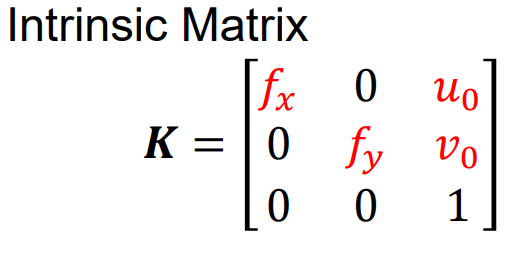

In [19]:
for i, fname in enumerate(images):
    img = cv.imread(fname)
    h, w = img.shape[:2]
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
    # undistort
    dst = cv.undistort(img, mtx, dist, None, newcameramtx)
     
    # crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    cv.imwrite(f'./undist_images/undist_result{i}.jpg', dst)
    cv.imshow('undist_img', dst)
    cv.waitKey(1500)
    
cv.destroyAllWindows()

Here we undistort the parameter, to do that we iterate over all the images, we get the optimal new cameral and then we use the built-in openCV method __undistort__.  
After that we crop the image and save it locally

### Images
The 10 images used for the chessboard calibration are taken using the front camera of a Google Pixel 6a.
These images are 2464 x 3280 pixel (around 8 MP) with an aspect ration of 3:4.
The camera specification are:

    - f/2.0, where 2.0 is the f-number which determine the depth of field, see picture 1
    
    - 1/100, shutter time, the camera sensor is open only for 0.01 seconds
    
    - 2.5mm, actual focal length, distance between the lens and the focal point when the lens are focused on a infinite distant object. When focusing on  a infinite distant object the light rays are all parallel as shown in the picture 2

__Picture 1__  
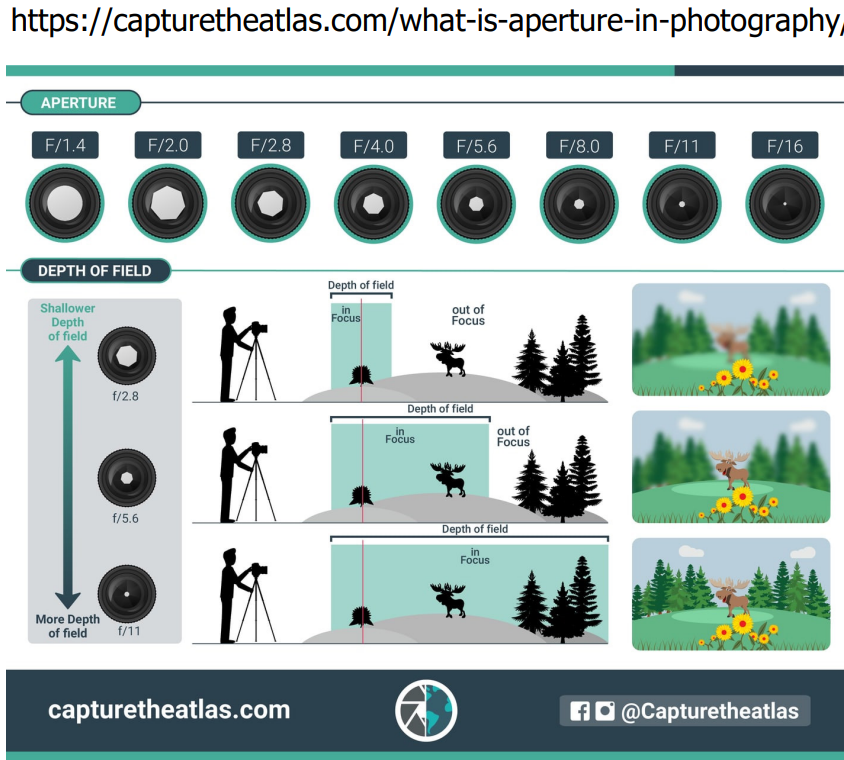 

__Picture 2__  
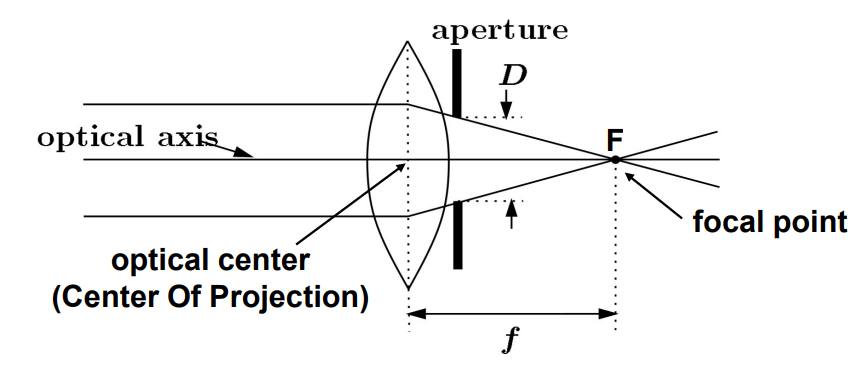   
the University of Washington CSE 576 (Graduate Computer Vision) slides


### 35mm equivalent
Sometimes the manufacturers publish digital camera datasheet's focal length in a 35mm equivalent, so __not in the actual length__.
The 35mm equivalent refers to cameras with a full-frame 24mm * 36mm. This standard is used so that we can easily compare camera specs, like the Field of View.

actual_focal_length = focal_length_35mm / crop_ratio.

This crop ratio can be calculated by this formula:

crop_ratio = diag_full_frame_camera / diag_camera

diag_full_frame_camera = sqrt(24^2 + 35^2) = 43.3 mm  
diag_camera = sqrt((pixel_length * img_width_pixel)^2 + (pixel_length * img_height_pixel)^2) = 4.6mm  
&emsp;where the pixel_length is usually provided by the manufacturer, in this case 1.12 micrometer,  
&emsp;img_width_pixel is 2464,     
&emsp;img_heigth_pixel is 3280

Thus the formula above result in: crop_ratio = 9.4  
Thus actual_focal_length = 0.94mm

The calculated focal lenght is quite __different__ from the expected one, 0.94mm compared to 2.5mm

### Extrinsic Parameters
Now let's see what are the estimated values of the extrinsic parameters:

In [ ]:
rvecs

In [ ]:
tvecs

## Draw on 3D space
Now let's draw on the 3d space defined by the XY plane of the flat chessboard and the Z axis perpendicular to the plane.
Let's try to draw XYZ axis.  
For this part we can see the example from OpenCV documentation: https://docs.opencv.org/3.4/d7/d53/tutorial_py_pose.html

In [6]:
def draw(img, corners, imgpts):
 corner = tuple(corners[0].ravel().astype(int))
 img = cv.line(img, corner, tuple(imgpts[0].ravel().astype(int)), (255,0,0), 5)
 img = cv.line(img, corner, tuple(imgpts[1].ravel().astype(int)), (0,255,0), 5)
 img = cv.line(img, corner, tuple(imgpts[2].ravel().astype(int)), (0,0,255), 5)
 return img

This is a simple draw function, note the astype(int) method calls. We need it because the cv.line requires __integer__ parameters but from the pointProjection we obtain float values

In [20]:
def draw_box(img, corners, imgpts):
    imgpts = np.int32(imgpts).reshape(-1,2)
    # draw ground floor in green
    img = cv.drawContours(img, [imgpts[:4]],-1,(0,255,0),-3)
    # draw pillars in blue color
    for i,j in zip(range(4), range(4,8)):
        img = cv.line(img, tuple(imgpts[i]), tuple(imgpts[j]),(255),3)
    # draw top layer in red color
    img = cv.drawContours(img, [imgpts[4:]],-1,(0,0,255),3)
    return img

draw_box simply draw a box

In [5]:
axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3) #For axis

To draw the axis we need to connect the origin to one point per each axis. For axis X (3, 0, 0), axis Y (0, 3, 0), for axis Z (0, 0, -3)
The units of this plane are taken accoriding to the points from the chessboard, so 3 unit is 3 chessboard squares.

In [21]:
axis = np.float32([[0,0,0], [0,3,0], [3,3,0], [3,0,0],
 [0,0,-3],[0,3,-3],[3,3,-3],[3,0,-3] ]) #For a box

To draw a boxes we use the same approach, but we need 8 points.

In [22]:
undist_images = glob.glob("./undist_images/*.jpg")
for i, fname in enumerate(undist_images): #use undist_images to draw on undistorted images
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Try to find the chessboard corners for the current image
    ret, corners = cv.findChessboardCorners(gray, (8,6), None)
    if ret:
        corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        # Project 3D points to image plane
        imgpts, jac = cv.projectPoints(axis, rvecs[i], tvecs[i], mtx, dist)
        img = draw_box(img, corners2, imgpts)

        cv.imshow('img_axis', img)
        cv.imwrite(f'./output_images/output_image_{i}.jpg', img)
        if cv.waitKey(500) == 27:  # exit if ESC is pressed
            break
    else:
        print(f"Chessboard not found in {fname}")

cv.destroyAllWindows()

Here we use the method __projectPoints__ to project our 3D points (0, 0, 0), (0, 3, 0) etc. to the 2D plane of the image.  
To do that we use the __rotation__ and __traslation__ vectors we found before by calling the calibrate function